In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Read data

In [2]:
df_train = pd.read_csv('train.tsv',sep='\t')

In [3]:
df_train.head(2)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2


In [4]:
print 'Train shape: {}'.format(df_train.shape)
print 'Number of unique sentences: {}'.format(len(df_train.loc[:, 'SentenceId'].unique()))

Train shape: (156060, 4)
Number of unique sentences: 8529


## 1.1 Distribution of sentiments

In [5]:
col_sentiment = df_train.loc[:,'Sentiment']

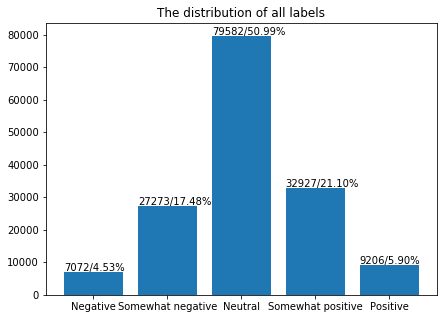

In [6]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
plt.title('The distribution of all labels')
bins = [-0.4, 0.4,0.6, 1.4, 1.6, 2.4, 2.6, 3.4, 3.6,4.4 ]
counts, bins, patches = plt.hist(col_sentiment, bins=bins, align='mid')

for i in xrange(5):
    s = str(int(counts[2*i])) + '/{:.2f}%'.format(counts[2*i]/sum(counts)*100)
    ax.text(i-0.4, counts[2*i]+400, s)

xlabels = ['Negative', 'Somewhat negative', 'Neutral', 'Somewhat positive', 'Positive']
_ = ax.set_xticklabels([''] + xlabels)

del col_sentiment

This dataset is imbalanced, half of its labels are Neutral 

## 1.2 Distribution of sentence sentiments

In [7]:
df_sentences = df_train.drop_duplicates(subset='SentenceId', keep='first')
print 'DF shape:{}'.format(df_sentences.shape)

DF shape:(8529, 4)


In [8]:
df_sentences.head(2)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4


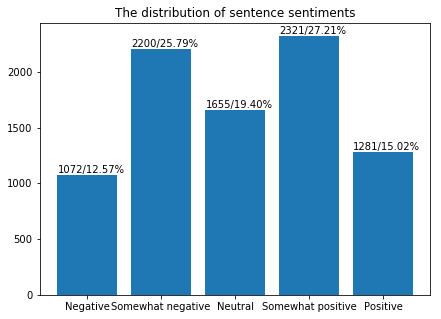

In [9]:
col_sentence_sentiment = df_sentences.loc[:,'Sentiment']

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
plt.title('The distribution of sentence sentiments')
bins = [-0.4, 0.4,0.6, 1.4, 1.6, 2.4, 2.6, 3.4, 3.6,4.4 ]
counts, bins, patches = plt.hist(col_sentence_sentiment, bins=bins, align='mid')

for i in xrange(5):
    s = str(int(counts[2*i])) + '/{:.2f}%'.format(counts[2*i]/sum(counts)*100)
    ax.text(i-0.4, counts[2*i]+20, s)

xlabels = ['Negative', 'Somewhat negative', 'Neutral', 'Somewhat positive', 'Positive']
_ = ax.set_xticklabels([''] + xlabels)

del col_sentence_sentiment, df_sentences

Above figures reveal differences between sentence sentiments and dataset sentiments. 

### 文本处理类
(1)所有word均小写化处理  
(2)使用空格代替除了[a-zA-Z.!?]的所有字符

In [10]:
from scipy.sparse import csc_matrix
import numpy as np
from copy import deepcopy
import re

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

class WordDictionary:
    """
    case insensitive 
    """
    def __init__(self, n_grams=1, lemmatization=False):
        self.word2index = {'<unknown>':0}
        self.index2word = {0:'<unknown>'}
        self.n_words = 1
        self.wordCounts = {}
        self.n_grams = n_grams
        self.lemmatization = lemmatization
    def addSentence(self, sentence):
        s = sentence.lower()
        s = re.sub(r'[^a-zA-Z.!?]',r' ', s)
        words = s.split()

        for idx in xrange(len(words)):
            for i in xrange(self.n_grams):
                if idx+i<len(words):
                    original_word = " ".join(words[idx:idx+i+1])
                    self.addWord(original_word)
                    if self.lemmatization:
                        lemmatized_word = self.lemmatizeWord(original_word)
                        if lemmatized_word!=original_word:
                            self.addWord(lemmatized_word)
                else:
                    break
    def addWord(self, word):
        if not self.word2index.has_key(word):
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1
            self.wordCounts[word] = 1
        else:
            self.wordCounts[word] += 1
    def lemmatizeWord(self, word):
        """
        word: can be blank separated word
        """
        word_ = word.split()
        lemmatized_words = []
        for w in word_:
            lemmatized_words.append(wnl.lemmatize(w))
        return " ".join(lemmatized_words)
    
    def filterWords(self, min_val = None, max_val=None, verbose=True):
        """
        min_val: int. Occurrence counts lower than this value will be returned.
        max_val: int. Occurrence counts bigger than this value will be returned. 
        """
        words = []
        print_words = []
        for k, v in self.wordCounts.iteritems():
            if min_val!=None and v <= min_val:
                words.append(k)
                print_words.append((k,v))
            if max_val!=None and v >= max_val:
                words.append(k)
                print_words.append((k,v))
        if verbose:
            print print_words
        return words
    def dropAndReindex(self, dropWords):
        """
        dropWords: delete word in dropWords
        """
        need_reindex = False
        for word in dropWords:
            if self.word2index.has_key(word):
                self.word2index.pop(word)
                self.wordCounts.pop(word)
                need_reindex = True
        if need_reindex:
            self.n_words = 1
            tmp_dict = deepcopy(self.word2index)
            self.word2index = {'<unknown>':0}
            self.index2word = {0:'<unknown>'}  
            for k,v in tmp_dict.iteritems():
                self.word2index[k] = self.n_words
                self.index2word[self.n_words] = word
                self.n_words += 1
            print "Finish reindex"
        else:
            print 'No need to reindex'
    
    def convertToVector(self, sentence, count=True, sparse=False):
        """
        sentence: str, blank seperated sentence
        count:boolean. If yes, the vector's entry means the number of occurrence
        sparse: boolean. If yes, the vector will be sparse
        """
        words = sentence.lower().split()
        data = []
        for idx in xrange(len(words)):
            for i in xrange(self.n_grams):
                if idx+i<len(words):
                    original_word = " ".join(words[idx:idx+i+1])
                    if self.word2index.has_key(original_word):
                        data.append(self.word2index[original_word])
                    else:
                        data.append(self.word2index['<unknown>'])                    
                    if self.lemmatization:
                        lemmatized_word = self.lemmatizeWord(original_word)
                        if lemmatized_word!=original_word:
                            if self.word2index.has_key(lemmatized_word):
                                data.append(self.word2index[lemmatized_word])                         
                else:
                    break
        if not count:
            data = np.unique(data)
        if sparse:
            length = len(data)
            res = csc_matrix((np.ones(length), (np.zeros(length), data)), shape=(1, self.n_words))
        else:
            res = np.zeros((1, self.n_words))
            for d in data:
                res[0, d] += 1
        return res
        

### 数据集拆分以及word向量化方法
由于数据中大量存在0，所以这里使用了sparse的表示方法来表示词向量

In [11]:
import random
import scipy
from scipy.sparse import vstack

def val_split(df, val_size=0.2):
    """
    This method considers Stratified sampling.
    """
    y = df.iloc[:, -1]
    classes = y.unique()
    train_idx = []
    val_idx = []
    for class_ in classes:
        bool_indexes = (y==class_)
        indexes = y[bool_indexes].index.tolist()
        length = len(indexes)
        random.shuffle(indexes)
        train_idx.extend(indexes[:-int(length*val_size)])
        val_idx.extend(indexes[-int(length*val_size):])
    random.shuffle(train_idx)
    random.shuffle(val_idx)
        
    return train_idx, val_idx

def word2index(df_data, words, count=True, sparse=True):
    Xs = []
    ys = []
    for data in df_data.itertuples():
        Xs.append(words.convertToVector(data[1],count=count, sparse=sparse))
        ys.append(data[2])
    if isinstance(Xs[0], scipy.sparse.csc.csc_matrix):
        Xs = vstack(Xs,format='csc')
    else:
        Xs = np.array(Xs)
    return Xs, np.asarray(ys)

### LogisticRegression模型相关的内容
由于数据不平衡，这里自动将各label的比例作为class_weight参与训练。

In [12]:
def AccuracyLossAndGradient(target, predicts, class_weight):
    xindex = np.arange(predicts.shape[0], dtype=int)
    yindex = np.zeros(predicts.shape[0],dtype=int)
    
    
    
    return loss, grads    

In [13]:
def CrossEntropyLossAndGradient(target, predicts, class_weights):
    xindex = np.arange(predicts.shape[0], dtype=int)
    yindex = np.zeros(predicts.shape[0],dtype=int)
    predict_idx = np.argmax(predicts, axis=1)
    
    class_weights = np.repeat(class_weights.reshape((1, predicts.shape[1])), predicts.shape[0], axis=0)
    class_weights = class_weights[xindex, 0]
    
    loss = -np.log(predicts[xindex, target])*class_weights
    
    grads = np.repeat(predicts[:,:1], predicts.shape[1], axis=1)
    grads[xindex, target] -= predicts[xindex, yindex]/predicts[xindex, target]
    loss = np.mean(loss)
    grads *= class_weights.reshape((-1, 1))
    return loss, grads

def get_batch_index(total_samples, batch_size):
    sindex = 0
    eindex = batch_size
    while eindex<total_samples:
        yield sindex, eindex
        sindex = eindex
        eindex += sindex
    if sindex<total_samples:
        yield sindex, total_samples
        
def SGD(f, w0, b0, Xs, ys, step=0.1, eps=0.00001, iterations=20, 
                    print_every=10, batch_size=512, shuffle=False):
    iter = 0
    while iter<iterations:
        if shuffle:
            indexes = np.arange(X.shape[0])
            random.shuffle(indexes)
            Xs = Xs[indexes]
            ys = ys[indexes]
        for sindex, eindex in get_batch_index(Xs.shape[0], batch_size):
            x = Xs[sindex:eindex]
            y = ys[sindex:eindex]
            loss, gradW, gradB = f(w0, b0, Xs, ys)
            delta_w = step*gradW
            delta_b = step*gradB
            w0 = w0 - delta_w
            b0 = b0 - delta_b
        
        iter += 1
        if iter%print_every==0:
            print "[{}/{}] loss:{:.4f}".format(iter, iterations, loss)
        if np.sqrt(np.sum(delta_w*delta_w))<eps or loss<0.001:
            print "Small gradient or loss detects, finish looping..."
            break
    return w0, b0    

def GradientDescent(f, w0, b0, Xs, ys, step=1, eps=0.00001, iterations=200, 
                    print_every=10, batch_size=512, shuffle=False):
    """
    f(w0, b0, X, y): return loss, gradw, gradb
    """
    iter = 0
    while iter<iterations:
        losses = gradWs = gradBs = 0
        counter = 0
        if shuffle:
            indexes = np.arange(X.shape[0])
            random.shuffle(indexes)
            Xs = Xs[indexes]
            ys = ys[indexes]
        for sindex, eindex in get_batch_index(Xs.shape[0], batch_size):
            x = Xs[sindex:eindex]
            y = ys[sindex:eindex]
            loss, gradW, gradB = f(w0, b0, Xs, ys)
            losses += loss
            gradWs += gradW
            gradBs += gradB
            counter += 1
        
        losses /= counter
        gradWs /= counter
        gradBs /= counter
        
        delta_w = step*gradWs
        delta_b = step*gradBs
        w0 = w0 - delta_w
        b0 = b0 - delta_b
        
        iter += 1
        if iter%print_every==0:
            print "[{}/{}] loss:{:.4f}".format(iter, iterations, losses)
        if np.sqrt(np.sum(delta_w*delta_w))<eps or loss<0.001:
            print "Small gradient or loss detects, finish looping..."
            break
    return w0, b0
    
class LogisticRegression:
    def __init__(self, C=0.1, step=0.1):
        self.C = C
        self.step = step
    def fit(self, Xs, ys, val_Xs=None, val_ys=None, class_weights='balanced', loss_f=CrossEntropyLossAndGradient, 
            update=SGD, batch_size=4096, max_iter=200):
        n_classes = len(np.unique(ys))
        self.weights = np.zeros((Xs.shape[1], n_classes-1))
        self.bias = np.zeros((1, n_classes-1))
        
        if class_weights=='balanced':
            class_weights = np.bincount(ys)
            class_weights = float(max(class_weights))/class_weights
        else:
            class_weights = np.ones(n_classes)
        
        def f(w0, b0, x, y):
            if isinstance(x, scipy.sparse.csc.csc_matrix):
                mul = np.dot(x, csc_matrix(w0)).toarray()
            else:
                mul = np.dot(x, w0)
            predicts = np.exp(mul + b0)
            norm = 1 + np.sum(predicts, axis=1, keepdims=True)
            predicts = np.concatenate((np.ones((predicts.shape[0], 1)), predicts), axis=1)
            norm_predicts = predicts/norm
            loss, grads = loss_f(y, norm_predicts, class_weights)
            
            grads = predicts * grads
            gradW = np.dot(x.T, csc_matrix(grads[:, 1:])).toarray()
            gradW /= x.shape[0]
            gradB = np.mean(grads[:, 1:], axis=0)
            
            w_regularize = 0.5*np.sum(np.sqrt(np.sum(w0*w0, axis=0)))
            loss += self.C*w_regularize
            gradW += self.C*w0
            
            return loss, gradW, gradB
        
        self.weights, self.bias = update(f, self.weights, self.bias, Xs, ys, step=self.step, 
                                                  batch_size=batch_size, iterations=max_iter)
        
        if val_Xs!=None:
            print 'Validation accuracy:{:.4f}'.format(self.score(val_Xs, val_ys))
        
    def predict(self, X):
        if isinstance(X, scipy.sparse.csc.csc_matrix):
            mul = np.dot(X, csc_matrix(self.weights)).toarray()
        else:
            mul = np.dot(X, self.weights)
        probs = np.exp(mul + self.bias)
        probs = np.concatenate((np.ones((probs.shape[0], 1)), probs), axis=1)
        predicts = np.argmax(probs, axis=1)
        return predicts
    
    def score(self, X, y):
        predicts = self.predict(X)
        return np.sum(predicts==y,dtype=float)/X.shape[0]
    

### 使用20%的数据作为验证集(对比各种参数、特征选择的优劣) 
由于label分布不均匀，所以这里使用了Stratified的方式拆分数据集，保证train,val数据中各种label的比例是一致的。PS：这里没有再单独划分测试集是由于所有选择均未进行针对验证集的参数搜索(即不太可能出现对验证集overfitting)。

In [14]:
train_idx, val_idx = val_split(df_train.iloc[:, -2:], val_size=0.2)
#val_idx, test_idx = val_split(df_train.iloc[val_idx, -2:], val_size=0.33)

# 2. 不同特征的影响
以下四种特征  
（1)1-gram, binary
（2)1-gram, 计数，下同 
（3)1-gram, 使用lemmatization  
（4)1-gram, 使用lemmatization且删除仅出现一次的word和stop words   
（5)2-gram  

最终结果：

<table border="1" width=900>
<tr>
<th>Feature</th>
<th>Train loss</th>
<th>Val accuracy</th>
<th>Time</th>
</tr>
<tr>
<td>1-gram, binary</td>
<td>12.1930</td>
<td>0.5652</td>
<td>1min 51s</td>
</tr>
<tr>
<td>1-gram, count</td>
<td>12.2055</td>
<td>0.5639</td>
<td>1min 53s</td>
</tr>
<tr>
<td>1-gram, count, lemmatization</td>
<td>12.1434</td>
<td>0.5652</td>
<td>1min 55s</td>
</tr>
<tr>
<td>1-gram, count, lemmatization, trim words</td>
<td>12.1707</td>
<td>0.5655</td>
<td>2min</td>
</tr>
<tr>
<td>2-gram, count</td>
<td>12.7899</td>
<td>0.5774</td>
<td>4min 59s</td>
</tr>
</table>

其它训练参数，均保持一致。例如优化算法SGD，lr=0.1, C=0.001(l2正则比例)，200个iteration

结果显示：效果最好的是2-gram，count。其次是1-gram+count+lemmatization+trim words. 

In [15]:
random.seed(1234)
lg = LogisticRegression(C=0.001, step=0.1)

## 2.1. one-gram, binary

In [16]:
wordDictionary = WordDictionary(n_grams=1, lemmatization=False)

for data in df_train['Phrase']:
    wordDictionary.addSentence(data)

print "Train vocabulary size: {}".format(wordDictionary.n_words)

#向量化
train_Xs,train_ys = word2index(df_train.iloc[train_idx, -2:], wordDictionary, count=False)
val_Xs, val_ys = word2index(df_train.iloc[val_idx, -2:], wordDictionary, count=False)
print 'trainX shape:{}'.format(train_Xs.shape)

Train vocabulary size: 15181
trainX shape:(124850, 15181)


In [17]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, update=SGD, max_iter=200)

[10/200] loss:13.7027
[20/200] loss:13.4544
[30/200] loss:13.2877
[40/200] loss:13.1539
[50/200] loss:13.0414
[60/200] loss:12.9441
[70/200] loss:12.8583
[80/200] loss:12.7813
[90/200] loss:12.7114
[100/200] loss:12.6473
[110/200] loss:12.5880
[120/200] loss:12.5328
[130/200] loss:12.4812
[140/200] loss:12.4326
[150/200] loss:12.3867
[160/200] loss:12.3432
[170/200] loss:12.3018
[180/200] loss:12.2624
[190/200] loss:12.2248
[200/200] loss:12.1889
Validation accuracy:0.5677
CPU times: user 1min 52s, sys: 4 ms, total: 1min 52s
Wall time: 1min 52s


In [19]:
%%time
lg = LogisticRegression(C=0.0, step=5.5)
lg.fit(train_Xs, train_ys, val_Xs, val_ys, class_weights=None, update=SGD, max_iter=200)

[10/200] loss:1.3405
[20/200] loss:1.2912
[30/200] loss:1.2559
[40/200] loss:1.2275
[50/200] loss:1.2035
[60/200] loss:1.1825
[70/200] loss:1.1639
[80/200] loss:1.1472
[90/200] loss:1.1319
[100/200] loss:1.1179
[110/200] loss:1.1049
[120/200] loss:1.0929
[130/200] loss:1.0817
[140/200] loss:1.0712
[150/200] loss:1.0613
[160/200] loss:1.0519
[170/200] loss:1.0431
[180/200] loss:1.0347
[190/200] loss:1.0268
[200/200] loss:1.0192
Validation accuracy:0.6148
CPU times: user 1min 56s, sys: 16 ms, total: 1min 56s
Wall time: 1min 56s


## 2.2. one-gram

In [41]:
wordDictionary = WordDictionary(n_grams=1, lemmatization=False)

for data in df_train['Phrase']:
    wordDictionary.addSentence(data)

print "Train vocabulary size: {}".format(wordDictionary.n_words)

#向量化
train_Xs,train_ys = word2index(df_train.iloc[train_idx, -2:], wordDictionary)
val_Xs, val_ys = word2index(df_train.iloc[val_idx, -2:], wordDictionary)
print 'trainX shape:{}'.format(train_Xs.shape)

Train vocabulary size: 15181
trainX shape:(124850, 15181)


In [42]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, update=SGD, max_iter=200)

[10/200] loss:13.7135
[20/200] loss:13.4521
[30/200] loss:13.2838
[40/200] loss:13.1537
[50/200] loss:13.0454
[60/200] loss:12.9517
[70/200] loss:12.8687
[80/200] loss:12.7938
[90/200] loss:12.7254
[100/200] loss:12.6624
[110/200] loss:12.6038
[120/200] loss:12.5491
[130/200] loss:12.4977
[140/200] loss:12.4493
[150/200] loss:12.4035
[160/200] loss:12.3600
[170/200] loss:12.3186
[180/200] loss:12.2792
[190/200] loss:12.2416
[200/200] loss:12.2055
Validation accuracy:0.5639
CPU times: user 1min 53s, sys: 0 ns, total: 1min 53s
Wall time: 1min 53s


## 2.3. 1-gram, 使用lemmatization 

In [31]:
wordDictionary = WordDictionary(n_grams=1, lemmatization=True)

for data in df_train['Phrase']:
    wordDictionary.addSentence(data)

print "Train vocabulary size: {}".format(wordDictionary.n_words)

#向量化
train_Xs,train_ys = word2index(df_train.iloc[train_idx, -2:], wordDictionary)
val_Xs, val_ys = word2index(df_train.iloc[val_idx, -2:], wordDictionary)
print 'trainX shape:{}'.format(train_Xs.shape)

Train vocabulary size: 15759
trainX shape:(124850, 15759)


In [32]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, update=SGD, max_iter=200)

[10/200] loss:13.6924
[20/200] loss:13.4152
[30/200] loss:13.2374
[40/200] loss:13.1016
[50/200] loss:12.9898
[60/200] loss:12.8940
[70/200] loss:12.8095
[80/200] loss:12.7337
[90/200] loss:12.6647
[100/200] loss:12.6012
[110/200] loss:12.5424
[120/200] loss:12.4875
[130/200] loss:12.4360
[140/200] loss:12.3875
[150/200] loss:12.3416
[160/200] loss:12.2981
[170/200] loss:12.2567
[180/200] loss:12.2172
[190/200] loss:12.1795
[200/200] loss:12.1434
Validation accuracy:0.5652
CPU times: user 1min 55s, sys: 4 ms, total: 1min 55s
Wall time: 1min 55s


## 2.4. 1-gram, 使用lemmatization且删除仅出现一次的word和stop words   

In [33]:
wordDictionary = WordDictionary(n_grams=1, lemmatization=True)

for data in df_train['Phrase']:
    wordDictionary.addSentence(data)

print "Train vocabulary size: {}".format(wordDictionary.n_words)

#删除词语
onetime_words = wordDictionary.filterWords(min_val=1)
stop_words = ['a','an','the','at', 'on', 'in']
drop_words = onetime_words + stop_words

wordDictionary.dropAndReindex(drop_words)

#向量化
train_Xs,train_ys = word2index(df_train.iloc[train_idx, -2:], wordDictionary)
val_Xs, val_ys = word2index(df_train.iloc[val_idx, -2:], wordDictionary)
print 'trainX shape:{}'.format(train_Xs.shape)

Train vocabulary size: 15759
[('y', 1), ('tu', 1), ('prechewed', 1), ('aggrieved', 1), (u'casing', 1), ('recovers', 1), ('roland', 1), ('lifted', 1), ('credulity', 1), ('omitted', 1), ('petter', 1), ('harmlessly', 1), ('retrospective', 1), ('foreshadowing', 1), ('marinated', 1), ('casings', 1), ('piles', 1), ('implied', 1), ('underventilated', 1), ('unsaid', 1), ('joshua', 1), ('upends', 1), ('anciently', 1), ('overstylized', 1), ('luis', 1)]
Finish reindex
trainX shape:(124850, 15729)


In [34]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, update=SGD, max_iter=200)

[10/200] loss:13.7368
[20/200] loss:13.4548
[30/200] loss:13.2756
[40/200] loss:13.1393
[50/200] loss:13.0271
[60/200] loss:12.9306
[70/200] loss:12.8455
[80/200] loss:12.7688
[90/200] loss:12.6990
[100/200] loss:12.6347
[110/200] loss:12.5751
[120/200] loss:12.5194
[130/200] loss:12.4672
[140/200] loss:12.4180
[150/200] loss:12.3715
[160/200] loss:12.3274
[170/200] loss:12.2855
[180/200] loss:12.2455
[190/200] loss:12.2073
[200/200] loss:12.1707
Validation accuracy:0.5655
CPU times: user 2min, sys: 12 ms, total: 2min
Wall time: 2min


## 2.5. two-gram  

In [35]:
wordDictionary = WordDictionary(n_grams=2, lemmatization=False)

for data in df_train['Phrase']:
    wordDictionary.addSentence(data)

print "Train vocabulary size: {}".format(wordDictionary.n_words)

#向量化
train_Xs,train_ys = word2index(df_train.iloc[train_idx, -2:], wordDictionary)
val_Xs, val_ys = word2index(df_train.iloc[val_idx, -2:], wordDictionary)
print 'trainX shape:{}'.format(train_Xs.shape)

Train vocabulary size: 98401
trainX shape:(124850, 98401)


In [36]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, update=SGD, max_iter=200, batch_size=128)

[10/200] loss:17.9426
[20/200] loss:13.1355
[30/200] loss:14.3905
[40/200] loss:14.0615
[50/200] loss:13.8706
[60/200] loss:14.5525
[70/200] loss:14.1135
[80/200] loss:13.6519
[90/200] loss:13.8325
[100/200] loss:13.9594
[110/200] loss:13.5596
[120/200] loss:13.3854
[130/200] loss:13.2536
[140/200] loss:13.3453
[150/200] loss:13.1500
[160/200] loss:13.1256
[170/200] loss:12.9953
[180/200] loss:12.9514
[190/200] loss:12.8524
[200/200] loss:12.7899
Validation accuracy:0.5774
CPU times: user 4min 59s, sys: 0 ns, total: 4min 59s
Wall time: 4min 59s


# 3. GD与SGD对比
特征: 1-gram, binary.  
learning rate: 0.1, C:0.001, iterations: 200.  
PS: SGD在上节中已测试，这里只使用GD再跑一次

<table border="1" width=900>
<tr>
<th>Algorithm</th>
<th>Train loss</th>
<th>Val accuracy</th>
<th>Time</th>
</tr>
<tr>
<td>SGD</td>
<td>12.1930</td>
<td>0.5652</td>
<td>1min 51s</td>
</tr>
<tr>
<td>GD</td>
<td>13.2431</td>
<td>0.5388</td>
<td>1min 53s</td>
</tr>
</table>

这里显示相同参数下，SGD能得到更高的validation accuracy.

In [43]:
wordDictionary = WordDictionary(n_grams=1, lemmatization=False)

for data in df_train['Phrase']:
    wordDictionary.addSentence(data)

print "Train vocabulary size: {}".format(wordDictionary.n_words)

#向量化
train_Xs,train_ys = word2index(df_train.iloc[train_idx, -2:], wordDictionary, count=False)
val_Xs, val_ys = word2index(df_train.iloc[val_idx, -2:], wordDictionary, count=False)
print 'trainX shape:{}'.format(train_Xs.shape)

Train vocabulary size: 15181
trainX shape:(124850, 15181)


In [44]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, update=GradientDescent, max_iter=200)

[10/200] loss:14.6441
[20/200] loss:14.1728
[30/200] loss:13.9739
[40/200] loss:13.8538
[50/200] loss:13.7691
[60/200] loss:13.7035
[70/200] loss:13.6495
[80/200] loss:13.6029
[90/200] loss:13.5616
[100/200] loss:13.5239
[110/200] loss:13.4890
[120/200] loss:13.4563
[130/200] loss:13.4254
[140/200] loss:13.3961
[150/200] loss:13.3680
[160/200] loss:13.3411
[170/200] loss:13.3153
[180/200] loss:13.2903
[190/200] loss:13.2663
[200/200] loss:13.2431
Validation accuracy:0.5388
CPU times: user 1min 53s, sys: 8 ms, total: 1min 53s
Wall time: 1min 53s


# 4. Learning rate的选择。
特征: 1-gram, binary.  
C:0.001, iterations: 200.  
PS: lr=0.1已经跑过了，这里只跑0.05, 0.5, 1

<table border="1" width=900>
<tr>
<th>Learning rate</th>
<th>Train loss</th>
<th>Val accuracy</th>
<th>Time</th>
</tr>
<td>0.05</td>
<td>12.6509</td>
<td>0.5536</td>
<td>1min 51s</td>
<tr>
<td>0.1</td>
<td>12.1930</td>
<td>0.5652</td>
<td>1min 51s</td>
</tr>
<tr>
<td>0.5</td>
<td>12.3858</td>
<td><font color='red'>0.5883</font></td>
<td>1min 47s</td>
</tr>
<tr>
<td>1</td>
<td>29.9642</td>
<td>0.3516</td>
<td>1min 47s</td>
</tr>
</table>

In [47]:
lg = LogisticRegression(C=0.001, step=0.05)

In [48]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, update=SGD, max_iter=200)

[10/200] loss:13.9693
[20/200] loss:13.7015
[30/200] loss:13.5601
[40/200] loss:13.4550
[50/200] loss:13.3669
[60/200] loss:13.2894
[70/200] loss:13.2197
[80/200] loss:13.1563
[90/200] loss:13.0980
[100/200] loss:13.0442
[110/200] loss:12.9941
[120/200] loss:12.9472
[130/200] loss:12.9031
[140/200] loss:12.8616
[150/200] loss:12.8222
[160/200] loss:12.7847
[170/200] loss:12.7491
[180/200] loss:12.7150
[190/200] loss:12.6823
[200/200] loss:12.6509
Validation accuracy:0.5536
CPU times: user 1min 51s, sys: 0 ns, total: 1min 51s
Wall time: 1min 51s


In [69]:
lg = LogisticRegression(C=0.001, step=6.25)

In [70]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, class_weights=None, update=SGD, max_iter=200)

[10/200] loss:1.4949
[20/200] loss:1.4652
[30/200] loss:1.4508
[40/200] loss:1.4428
[50/200] loss:1.4381
[60/200] loss:1.4352
[70/200] loss:1.4335
[80/200] loss:1.4324
[90/200] loss:1.4317
[100/200] loss:1.4313
[110/200] loss:1.4310
[120/200] loss:1.4309
[130/200] loss:1.4308
[140/200] loss:1.4307
[150/200] loss:1.4306
[160/200] loss:1.4306
[170/200] loss:1.4306
[180/200] loss:1.4306
[190/200] loss:1.4306
[200/200] loss:1.4306
Validation accuracy:0.4463
CPU times: user 1min 52s, sys: 8 ms, total: 1min 52s
Wall time: 1min 52s


In [51]:
lg = LogisticRegression(C=0.001, step=1)

In [52]:
%%time
lg.fit(train_Xs, train_ys, val_Xs, val_ys, update=SGD, max_iter=200)

[10/200] loss:39.8443
[20/200] loss:37.7512
[30/200] loss:36.2919
[40/200] loss:35.1643
[50/200] loss:34.2796
[60/200] loss:33.5689
[70/200] loss:32.9854
[80/200] loss:32.4984
[90/200] loss:32.0869
[100/200] loss:31.7358
[110/200] loss:31.4340
[120/200] loss:31.1729
[130/200] loss:30.9459
[140/200] loss:30.7475
[150/200] loss:30.5735
[160/200] loss:30.4203
[170/200] loss:30.2850
[180/200] loss:30.1653
[190/200] loss:30.0589
[200/200] loss:29.9642
Validation accuracy:0.3516
CPU times: user 1min 47s, sys: 0 ns, total: 1min 47s
Wall time: 1min 47s
